We became familiar with several ML techniques for Numeric prediction and Classification.

In this activity we will use Artificial Neural Networks (ANN) for prediction and compare it with one of the techniques we used earlier for numeric predictions (linear regression).

# Numeric prediction using regression

We will use the 50_startups dataset you are familiar with from activity 1.

In [26]:
import sklearn
print(sklearn.__version__)

1.2.2


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
#import dataset
import pandas as pd
df = pd.read_csv('50_Startups.csv')
#defining input and outcome variables
y = df[['Profit']]  #profit
#X = dataset.drop(labels=['Profit','State'], axis=1) #other variables
X = df.drop('Profit',axis=1) #other variables
#add the binary encoded State variables to our X variable
X=pd.concat([X,pd.get_dummies(X['State'])],axis=1)
# drop the State column, since we now have the binary encoded vars
X.drop(['State'],axis=1,inplace=True)
df.head(3)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39


In [12]:
y.head(2)

,Profit
0,192261.83
1,191792.06


In [13]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)  #using same random_state value for replicability


## Training a linear regression model with the train/test split

In [28]:
#### Fitting Multiple Linear Regression to the Training set  ####
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import StandardScaler
#lin_reg = LinearRegression(normalize= True)
#lin_reg.fit(X_train,Y_train)
# Fitting Multiple Linear Regression to the Training set  ####
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression()

### Predictive performance of regression model

In [29]:
# Predicting the Test set results
y_pred_lin = lin_reg.predict(X_test)

In [30]:
#model evaluation
from sklearn import metrics
import math
print("Mean squared error: %.2f" % (metrics.mean_squared_error(Y_test, y_pred_lin))) #MSE
print("Root Mean squared error: %.2f" % math.sqrt(metrics.mean_squared_error(Y_test, y_pred_lin))) #RMSE
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(Y_test, y_pred_lin)) # mean absolute error

Mean squared error: 50037959.16
Root Mean squared error: 7073.75
Mean absolute error: 5256.53


## Training the Regression model using k-fold CV

In [31]:
#training the regression model with k-fold Cross validation
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=5) #our data has only 50 observations
#we will output RMSE and MAE
scoremetrics=('neg_root_mean_squared_error','neg_mean_absolute_error')
for score in scoremetrics:
  cv_results = model_selection.cross_val_score(lin_reg, X, y, cv=kfold, scoring=score)
  msg = "%s: %f (%f)" % (score, -cv_results.mean(), cv_results.std())
  print(msg)

neg_root_mean_squared_error: 9484.933492 (3640.134244)
neg_mean_absolute_error: 7549.824962 (2752.092991)


In [33]:
#predict profit for a new startup (same dataset as in activity 2_numeric prediction)
X_new=pd.read_csv('50_Startups_newinput1.csv')
print(X_new)
lin_reg.predict(X_new)

   R&D Spend  Administration  Marketing Spend  CA  FL  NY
0      50000           50000            10000   0   1   0
1     100000          100000            20000   1   0   0


ValueError: ignored

# Using a Neural Network to predict numeric outcome (e.g., profit)

Let's use an Artificial Neural Network (ANN) for the same problem

In [34]:
#install some more things we need
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [35]:
#if you have not loaded these yet...
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [36]:
#%tensorflow_version 2.x
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.13.0


In [37]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## Setting up the NN architecture

In [38]:
# Just to make sure we have the right datasets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
#Our predictor/input variables
X_train.keys()

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'California',
       'Florida', 'New York'],
      dtype='object')

We define the following architecture for our ANN in the next cell and define it as a function:
* 1 input layer with 6 nodes; equal to the number of predictor/input variables (take a look at X-train again)
* 1 (or 2) fully-connected (dense) hidden layer with 64 (or 32) nodes
we use the Rectifier Linear (ReLu) activation function for the nodes in the hiddern layer
* 1 output layer with 1 node; since we have 1 continuous outcome variable

Later on we will add another hidder layer

In [39]:
def build_model():
  model = keras.Sequential([ #keras.Sequential creates a stack of layers (like a placeholder for layers we want to add)
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    #layers.Dense(64, activation='relu'), #uncomment this line to add a 2nd hidden layer later
    layers.Dense(1) # notice out output node does not have an activation function
  ])

  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)

  model.compile(loss='mse', #mean-square-error (MSE) is our loss function
                optimizer=optimizer,
                metrics=['mae', 'mse']) #keep both MAE and MSE
  return model


In [40]:
#NOTE:run this cell if you want to delete the model and clear tf session
#tf.keras.backend.clear_session()
#del model

In [41]:
#call the above function once to create our model (just initializing it)
model=build_model()

In [42]:
# show model architecture (see below for details)
model.summary()
#Note: in dense_X  the number X merely keeps track of used layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


For the above NN architecture (the one with one dense layer with 64 nodes), the number of parameters that can be trained are 448. How so?
we have 1 parameter for each weight and 1 bias parameter for each node (except for our input nodes)
*   6x64=384 (weights connecting each input node to each node in the hidden layer) +
*   64 (bias parameter for nodes in the hidden layer)
*   = 448 parameters
*   64x1 (weights connecting each node in the hidden layer to the output node) +
*   1 (bias parameter for output node) = 65 parameters


### Question 1
If we would use 32 nodes in the hidden layer (instead of 64), how many trainable parameters would the network have?

You don't have to, but can change the network structure to have 32 nodes in the above cells and check the model architecture. If you o, make sure to change it back to 64 before proceeding.

Answer-If our hidden layer contains 32 nodes. 6 input nodes = 6 * 32 = 192 Each biased parameter has 32 nodes, + 32 more. The number of trainable parameters would be 257.

In [82]:
#let's take another look at our X-train dataset
X_train.head(1)

,R&D Spend,Administration,Marketing Spend,California,Florida,New York
21,78389.47,153773.43,299737.29,0,0,1


In [86]:
#making sure we can feed our data to the NN
model.predict((X_train[:20]))

1/1 [==============================] - 0s 39ms/step


array([[135400.67 ],
       [ 44965.855],
       [125111.98 ],
       [ 63990.125],
       [160723.39 ],
       [207210.1  ],
       [154540.95 ],
       [127880.71 ],
       [ 43414.89 ],
       [100270.86 ],
       [101748.766],
       [146107.14 ],
       [ 80741.44 ],
       [113320.56 ],
       [170867.19 ],
       [120571.48 ],
       [ 17554.666],
       [177651.3  ],
       [112485.41 ],
       [ 69546.805]], dtype=float32)

## Training the NN model on unscaled data

In [75]:
EPOCHS = 100
history = model.fit(
  X_train,Y_train,
  epochs=EPOCHS, validation_split = 0.1, verbose=0, #in each epoch, 10% of the data is used as the validation set after the NN trains on the other 90%
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:741179840.0000,  mae:23148.9941,  mse:741179840.0000,  val_loss:1290268544.0000,  val_mae:29960.5098,  val_mse:1290268544.0000,  
....................................................................................................

In [46]:
#take a look at the loss values for the first and last 5 epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head(5), hist.tail(5)

(           loss           mae           mse     val_loss       val_mae  \
 0  8.553927e+09  86486.781250  8.553927e+09  221098592.0  12706.198242   
 1  4.335616e+08  16483.941406  4.335616e+08  151995184.0   9725.330078   
 2  3.242941e+08  14296.133789  3.242941e+08  130724184.0   9495.171875   
 3  2.666082e+08  13323.778320  2.666082e+08   89046808.0   7725.956055   
 4  2.469806e+08  12877.270508  2.469806e+08  217534208.0  11785.991211   
 
        val_mse  epoch  
 0  221098592.0      0  
 1  151995184.0      1  
 2  130724184.0      2  
 3   89046808.0      3  
 4  217534208.0      4  ,
            loss           mae          mse     val_loss       val_mae  \
 95  394286144.0  16298.176758  394286144.0  655741248.0  24875.775391   
 96  715950784.0  21585.113281  715950784.0  155876544.0  11198.542969   
 97  147483904.0   9827.665039  147483904.0  150112704.0  10906.654297   
 98  149373040.0   9860.524414  149373040.0  162805536.0  10985.932617   
 99  144687168.0   9625.303

The MAE values are high!

In [47]:
#using a plotter from tfdocs to visualize our NN's training
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Profit]')

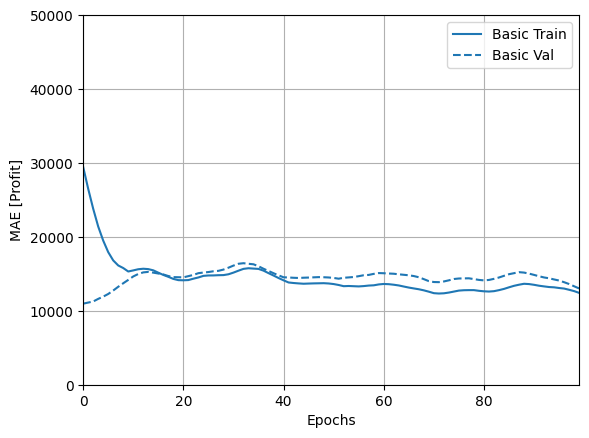

In [48]:
#plotting the error values per epoch; shows us how MAE goes down as network trains
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 50000])
#change the upper limit to roughly the MAE of your first epoch (from above cell)
plt.ylabel('MAE [Profit]')

Text(0, 0.5, 'MSE [Profit^2]')

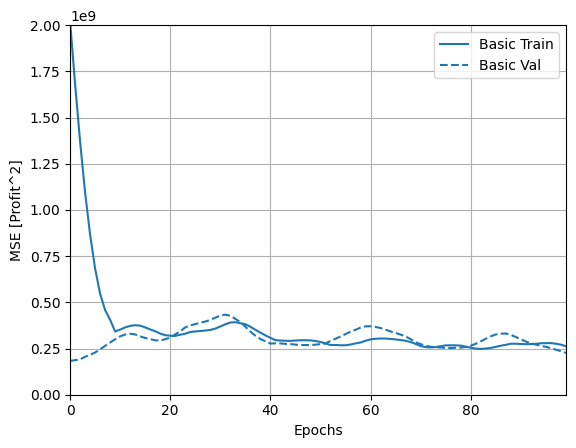

In [49]:
#similar plot for MSE
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 2e9])
#change the upper limit to roughly the MSE of your first epoch (from above cell)
plt.ylabel('MSE [Profit^2]')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

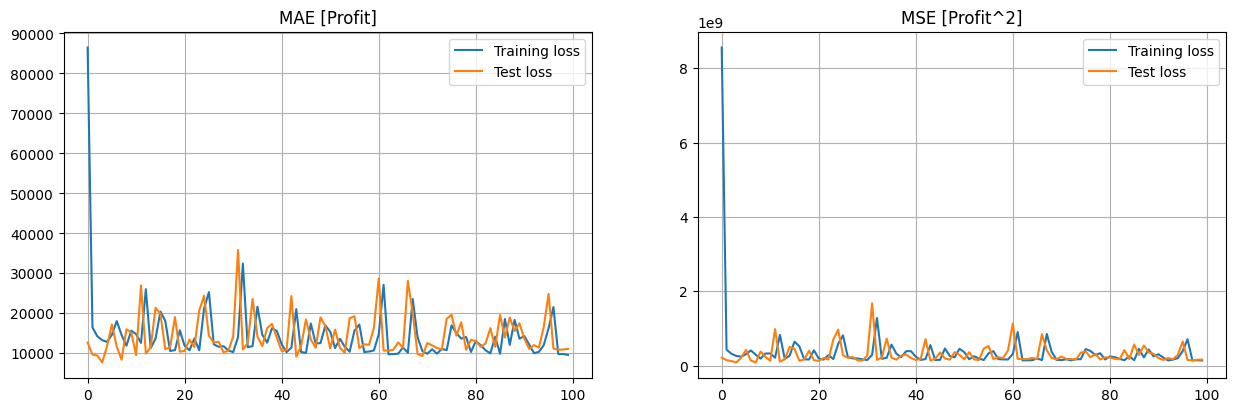

In [50]:
#another way to plot the Loss values per epoch (without using tensorflowDocs plotter)
#no smoothing
fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(15,4.5, forward=True)
axs[0].plot(hist['epoch'], hist["mae"])
axs[0].plot(hist['epoch'], hist["val_mae"])
axs[0].legend(['Training loss','Test loss'])
axs[0].set_title('MAE [Profit]')
axs[0].grid()
axs[1].plot(hist['epoch'], hist["mse"])
axs[1].plot(hist['epoch'], hist["val_mse"])
axs[1].legend(['Training loss','Test loss'])
axs[1].set_title('MSE [Profit^2]')
axs[1].grid()
plt.plot

Notice the values in both plots are high, but converge after epoch 20

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

### NN model performance (trained on unscaled data)

In [51]:
# let's evalute the trained NN on out test data (X_test)
y_pred=model.predict(X_test)
from sklearn import metrics
import math
#print('Coefficients: \n', lin_reg.coef_) #regression coefficients
print("Root Mean squared error: %.2f" % math.sqrt(metrics.mean_squared_error(Y_test, y_pred))) #RMSE
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(Y_test, y_pred))

1/1 [==============================] - 0s 39ms/step
Root Mean squared error: 19795.15
Mean absolute error: 14044.57


### Question 2
Does the NN model have a better predictive performance than the regression model?
...

**Answer**
NO, The NN model does NOT perform more predictably than the linear regression model.

## Train the NN model on scaled data (this is the right way)
Now we will train the model on the scaled data

In [52]:
#NOTE:this cell deletes the model and clears tf session
tf.keras.backend.clear_session()
del model
#delete the model to not keep any of the learned weights

In [53]:
#build same model again and
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
# Feature Scaling, we will use MinMax scaling
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc_X = StandardScaler()
sc_Y = StandardScaler()

In [55]:
#training the NN on scaled data (NOTE: this is the right way!)
EPOCHS = 100
history = model.fit(
  sc_X.fit_transform(X_train),sc_Y.fit_transform(Y_train),
  epochs=EPOCHS, validation_split = 0.1, verbose=0, #in each epoch, 10% of the data is used as the validation set after the NN trains on the other 90%
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.0679,  mae:0.8125,  mse:1.0679,  val_loss:1.7115,  val_mae:0.9843,  val_mse:1.7115,  
....................................................................................................

In [56]:
#take a look at the loss values for the first and last 5 epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head(5), hist.tail(5)

(       loss       mae       mse  val_loss   val_mae   val_mse  epoch
 0  1.067909  0.812467  1.067909  1.711525  0.984341  1.711525      0
 1  0.499587  0.548007  0.499587  1.075348  0.853073  1.075348      1
 2  0.306368  0.437139  0.306368  0.741035  0.741174  0.741035      2
 3  0.178512  0.309234  0.178512  0.381644  0.542305  0.381644      3
 4  0.111163  0.251599  0.111163  0.364599  0.454336  0.364599      4,
         loss       mae       mse  val_loss   val_mae   val_mse  epoch
 95  0.011347  0.079489  0.011347  0.098967  0.254791  0.098967     95
 96  0.010809  0.077624  0.010809  0.154721  0.327290  0.154721     96
 97  0.020376  0.111505  0.020376  0.056736  0.175284  0.056736     97
 98  0.037986  0.147731  0.037986  0.106133  0.268083  0.106133     98
 99  0.023121  0.124342  0.023121  0.135956  0.358891  0.135956     99)

Text(0, 0.5, 'MAE [Profit]')

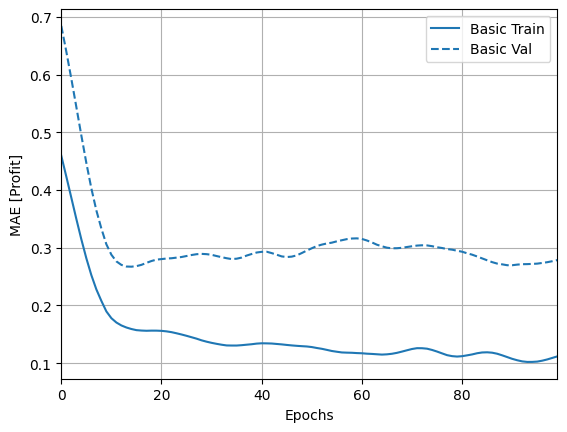

In [57]:
#plotting the error values per epoch; shows us how MAE goes down as network trains
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
#plt.ylim([0, 0.3])
#change the upper limit to roughly the MAE of your first epoch (from above cell)
plt.ylabel('MAE [Profit]')

Text(0, 0.5, 'MSE [Profit^2]')

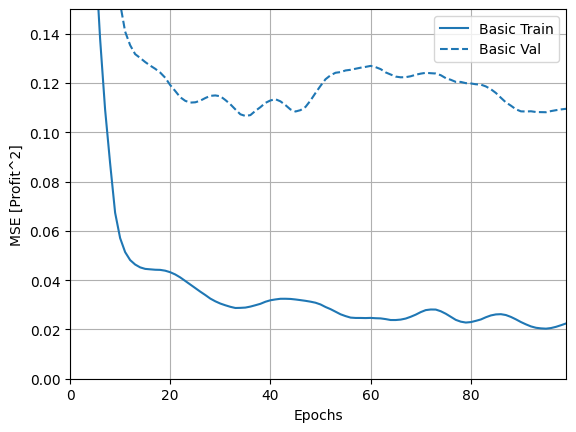

In [58]:
#similar plot for MSE
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 0.15])
#change the upper limit to roughly the MSE of your first epoch (from above cell)
plt.ylabel('MSE [Profit^2]')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

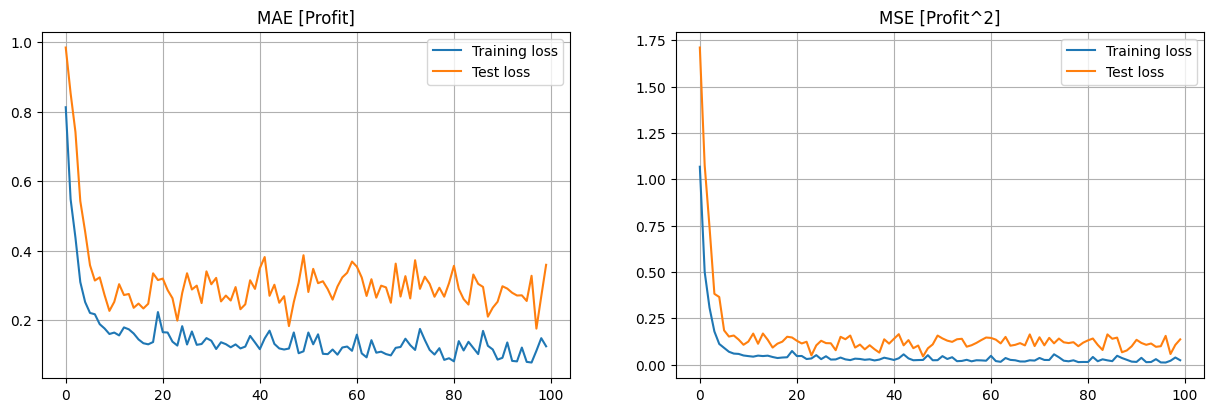

In [59]:
#another way to plot the Loss values per epoch (without using tensorflowDocs plotter)
#no smoothing
fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(15,4.5, forward=True)
axs[0].plot(hist['epoch'], hist["mae"])
axs[0].plot(hist['epoch'], hist["val_mae"])
axs[0].legend(['Training loss','Test loss'])
axs[0].set_title('MAE [Profit]')
axs[0].grid()
axs[1].plot(hist['epoch'], hist["mse"])
axs[1].plot(hist['epoch'], hist["val_mse"])
axs[1].legend(['Training loss','Test loss'])
axs[1].set_title('MSE [Profit^2]')
axs[1].grid()
plt.plot

### Question 3
At around which epoch (approximately) does the model not improve anymore?

ANSWER: Around epoch 20, the model stops improving better.

### NN model performance (trained on scaled data)

In [60]:
from sklearn import metrics
import math

Since we have trained the NN on scaled X_train, we need to scale the test data before feeding it to the trained NN model for predictions

Similarly, the resulting NN model predictions (*y_pred*) are scaled and we need to transform it back to its original scale (*sc_Y.inverse_transform(y_pred)* ) for a meaningful comparison with Y_test (profit values on the original scale in our test data)

In [61]:
# let's evaluate the trained NN model
# we need to scale the test data since we have trained the NN on scaled X
y_pred=model.predict(sc_X.transform(X_test))

print("RMSE: %.2f" % math.sqrt(metrics.mean_squared_error(Y_test, sc_Y.inverse_transform(y_pred)))) #RMSE
print("MAE: %.2f" % metrics.mean_absolute_error(Y_test, sc_Y.inverse_transform(y_pred))) #MAE

1/1 [==============================] - 0s 57ms/step
RMSE: 14499.14
MAE: 12074.16


In [62]:
sc_Y.inverse_transform(y_pred)

array([[126178.09 ],
       [121447.38 ],
       [ 87626.78 ],
       [ 72205.8  ],
       [125542.24 ],
       [191298.75 ],
       [ 58545.74 ],
       [121355.164],
       [ 98288.65 ],
       [144178.83 ]], dtype=float32)

Notice that the NN model's performance improves when we (correctly) train it on the scaled data.

In [63]:
# let's look at the metrics using the scaled outcome variable (Profit)
print("RMSE: %.2f" % math.sqrt(metrics.mean_squared_error(sc_Y.transform(Y_test), y_pred))) #RMSE
print("MAE: %.2f" % metrics.mean_absolute_error(sc_Y.transform(Y_test), y_pred))


RMSE: 0.36
MAE: 0.30


Remember RMSE and MAE are in the same unit as the outcome variable. So when we evaluate the model on the scaled Profit (i.e., profit ranges from 0 to 1) the RMSE and MAE values are naturally smaller. But we can't really interpret them in terms of dollar values.

## Comparing performance against Regression model


In [64]:
print("RMSE NN model: %.2f" % math.sqrt(metrics.mean_squared_error(Y_test, sc_Y.inverse_transform(y_pred)))) #RMSE
print("MAE NN model: %.2f" % metrics.mean_absolute_error(Y_test, sc_Y.inverse_transform(y_pred)) +"\n") #MAE

print("RMSE linear regression: %.2f" % math.sqrt(metrics.mean_squared_error(Y_test, y_pred_lin))) #RMSE
print("MAE linear regression: %.2f" % metrics.mean_absolute_error(Y_test, y_pred_lin))

RMSE NN model: 14499.14
MAE NN model: 12074.16

RMSE linear regression: 7073.75
MAE linear regression: 5256.53


### Question 4
As you can see, in our example the NN model performs worse than the Regression model. Why?

This is because we have a very small dataset; 50 observations and we use 40 of them for training. NNs performs well on large data, here our NN is "learning" (adjusting all those parameters) based on a very limited number of observations.

# Using a Neural network like a regression?!

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [66]:
tf.keras.backend.clear_session()
del model

In [67]:
def build_model():
  model = keras.Sequential([ #keras.Sequential creates a stack of layers (like a placeholder for layers we want to add)
    layers.Dense(units=1,activation=None, input_shape=[len(X_train.keys())])
  ])

  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)

  model.compile(loss='mse', #mean-square-error (MSE) is our loss function
                optimizer=optimizer,
                metrics=['mae', 'mse']) #keep both MAE and MSE
  return model

In [68]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 7 (28.00 Byte)
Trainable params: 7 (28.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
#training on unscaled data
EPOCHS = 100
history = model.fit(
  X_train,Y_train,
  epochs=EPOCHS, validation_split = 0.1, verbose=0, #in each epoch, 10% of the data is used as the validation set after the NN trains on the other 90%
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:77627211776.0000,  mae:255359.4688,  mse:77627211776.0000,  val_loss:77273800704.0000,  val_mae:241083.3750,  val_mse:77273800704.0000,  
....................................................................................................

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

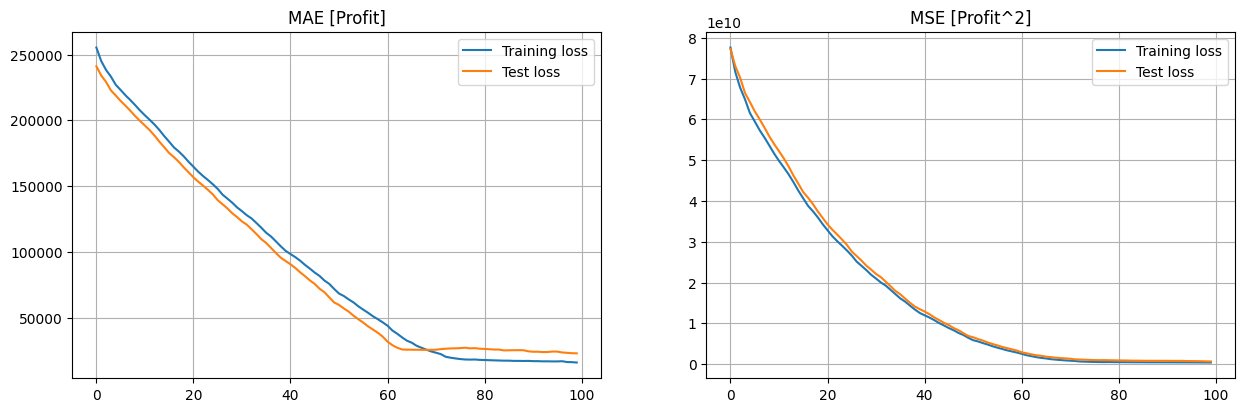

In [70]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(15,4.5, forward=True)
axs[0].plot(hist['epoch'], hist["mae"])
axs[0].plot(hist['epoch'], hist["val_mae"])
axs[0].legend(['Training loss','Test loss'])
axs[0].set_title('MAE [Profit]')
axs[0].grid()
axs[1].plot(hist['epoch'], hist["mse"])
axs[1].plot(hist['epoch'], hist["val_mse"])
axs[1].legend(['Training loss','Test loss'])
axs[1].set_title('MSE [Profit^2]')
axs[1].grid()
plt.plot

In [71]:
y_pred=model.predict(X_test)
print("Root Mean squared error: %.2f" % math.sqrt(metrics.mean_squared_error(Y_test, y_pred))) #RMSE
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(Y_test, y_pred))

1/1 [==============================] - 0s 135ms/step
Root Mean squared error: 24860.90
Mean absolute error: 16519.28


In [72]:
#training on scaled data
EPOCHS = 300
history = model.fit(
  sc_X.fit_transform(X_train),sc_Y.fit_transform(Y_train),
  epochs=EPOCHS, validation_split = 0.1, verbose=0, #in each epoch, 10% of the data is used as the validation set after the NN trains on the other 90%
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.5765,  mae:1.1080,  mse:1.5765,  val_loss:2.6135,  val_mae:1.2173,  val_mse:2.6135,  
....................................................................................................
Epoch: 100, loss:0.9458,  mae:0.8515,  mse:0.9458,  val_loss:1.8410,  val_mae:1.2164,  val_mse:1.8410,  
....................................................................................................
Epoch: 200, loss:0.4032,  mae:0.4987,  mse:0.4032,  val_loss:1.0004,  val_mae:0.9385,  val_mse:1.0004,  
....................................................................................................

In [73]:
y_pred=model.predict(sc_X.transform(X_test))

print("RMSE: %.2f" % math.sqrt(metrics.mean_squared_error(Y_test, sc_Y.inverse_transform(y_pred)))) #RMSE
print("MAE: %.2f" % metrics.mean_absolute_error(Y_test, sc_Y.inverse_transform(y_pred))) #MAE

1/1 [==============================] - 0s 49ms/step
RMSE: 10787.73
MAE: 7811.60
